## Load Libraries

In [28]:
import os
import numpy as np
import pandas as pd
from scipy import sparse
import tensorflow as tf
from tensorflow.keras.metrics import AUC
from tensorflow.keras.layers import Dense, Dropout,Input
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import categorical_accuracy #AUC 
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam,SGD
from spektral.layers import GINConv,GCNConv #, GCSConv, GlobalAvgPool
from spektral.utils.sparse import sp_matrix_to_sp_tensor
from spektral.data import DisjointLoader, BatchLoader, Dataset, Graph
from spektral.transforms.normalize_adj import NormalizeAdj
from spektral.transforms.normalize_one import NormalizeOne
from spektral.transforms.normalize_sphere import NormalizeSphere
from spektral.transforms import LayerPreprocess
import gc
import spektral.datasets
from spektral.data import DisjointLoader, BatchLoader
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from spektral.models.gcn import GCN 
from spektral.models.general_gnn import GeneralGNN
import glob

# Create Dataset Class

In [29]:
import os
import pandas as pd
import numpy as np
from scipy import sparse
import gc
from spektral.data import Dataset, Graph

# Custom dataset class
class MyDataset(Dataset):

    def __init__(self, graph_feature_files, ncol_files, **kwargs):
        # Store the graph feature and ncol file lists
        self.graph_feature_files = graph_feature_files
        self.ncol_files = ncol_files
        super().__init__(**kwargs)

    def download(self):
        pass

    def read(self):
        # We must return a list of Graph objects
        output = []

        # Iterate through graph_feature_files and ncol_files
        for graph_feature_file, ncol_file in zip(self.graph_feature_files, self.ncol_files):
            # Read graph features
            x_tmp = pd.read_csv(graph_feature_file, sep=",", header=0)
       
            # Read graph topology
            a_tmp = pd.read_csv(ncol_file, sep=" ", header=None, names=["source", "target", "weight"])

            ### FILTER LCC !=0
            ## Filter features files
            x_tmp = x_tmp[(x_tmp['LCC'] != 0) | (x_tmp['label'] == 'infected')]

            ## Get the list of nodes with LCC != 0
            filtered_nodes = set(x_tmp['node'].tolist())
        
            ## Filter the nodes file
            a_tmp_filtered = a_tmp[a_tmp['source'].isin(filtered_nodes) & a_tmp['target'].isin(filtered_nodes)]
            a_tmp = a_tmp_filtered

            # Replace background for normal
            x_tmp['label'] = x_tmp['label'].replace('background','normal')

            # Replace all non-zero values in the 'weight' column with 1
            a_tmp.loc[a_tmp['weight'] != 0, 'weight'] = 1
            
            # Create dictionaries that identify each node and label with an integer
            class_idx = {name: idx for idx, name in enumerate(sorted(x_tmp["label"].unique()))}
            node_idx = {name: idx for idx, name in enumerate(sorted(x_tmp["node"].unique()))}

            # Change node names and label for their corresponding integer
            x_tmp["node"] = x_tmp["node"].apply(lambda name: node_idx[name])
            x_tmp["label"] = x_tmp["label"].apply(lambda value: class_idx[value])
            a_tmp["source"] = a_tmp["source"].apply(lambda name: node_idx[name])
            a_tmp["target"] = a_tmp["target"].apply(lambda name: node_idx[name])

            # Node features: all but node and label
            x = x_tmp.sort_values("node")[x_tmp.columns.difference(["node","label"], sort=False)]
            # normalize Node features
            # x = (x - x.min()) / (x.max() - x.min()) #not necesary since I'm using weight =1
            # Convert to numpy
            x = x.to_numpy()
            x = x.astype(np.float32)

            # Create adjacency matrix from source, target, and weight
            a_source = a_tmp[["source"]].to_numpy().T
            a_source = np.reshape(a_source, a_source.shape[-1])
            a_target = a_tmp[["target"]].to_numpy().T
            a_target = np.reshape(a_target, a_target.shape[-1])
            a_weight = a_tmp[["weight"]].to_numpy().T
            a_weight = np.reshape(a_weight, a_weight.shape[-1])

            # Adjacency matrix:
            #a = sparse.coo_matrix((a_weight, (a_source, a_target)), shape=(x.shape[0], x.shape[0]))
            a = sparse.csr_matrix((a_weight, (a_source, a_target)), shape=(x.shape[0], x.shape[0]), dtype=np.float32)

            # Label (CTU13random):
            #y = []
            #for j in range(x_tmp.shape[0]):
            #     np.random.seed(200+j)
            #     y_tmp = np.random.randint(0,2)
            #     if y_tmp:
            #         y.append(np.array([1., 0.]))
            #     else:
            #         y.append(np.array([0., 1.]))
            #y = np.array(y)
            #y_one_hot = y.astype(np.int64)

            #y = []
            #for j in range(x_tmp.shape[0]):
            #    #if((x[j,0] > 1) or (x[j,1] > 1)): # Condition for CTU13balancedIDOD: 
            #    if (x_tmp.iloc[j,4] > 2):  
            #        y.append(np.array([0., 1.])) # clase 1 = "infected"
            #    else:
            #        y.append(np.array([1., 0.])) # clase 0 = "normal"
            #y = np.array(y)
            #y_one_hot = y.astype(np.float32)



            # Label:
            y = x_tmp.sort_values("node")["label"].to_numpy()
            y.astype(np.int64)
            y_one_hot = np.eye(2)[y]
            
            # Create a Graph object and add it to the output list
            output.append(Graph(x=x, a=a, y=y_one_hot))

            # Free memory
            del x_tmp, x, a_tmp, a_source, a_target, a_weight, a, y
            gc.collect()

        return output



## Instance CTU13 Dataset

In [30]:
# Create a list of graph feature files and ncol files
graph_feature_files = sorted(glob.glob("/mnt/CEPH/ctu13/features/*"))
ncol_files = sorted(glob.glob("/mnt/CEPH/ctu13/ncol/*"))
# Instantiate the dataset
#dataset = MyDataset(graph_feature_files, ncol_files,transforms=[NormalizeAdj(symmetric=False)])
dataset = MyDataset(graph_feature_files, ncol_files,transforms=[LayerPreprocess(GCNConv)])
#dataset = MyDataset(graph_feature_files, ncol_files)

In [31]:
for j in range(13):
    suma = 0
    for i in range(dataset[j].n_nodes):
        if all(dataset[j].y[i] == [0.,1.]):
            suma+=1
    print("cap ",j+1,": normal:",suma, " - infected:",dataset[j].n_nodes-suma, " -- prop:",suma/dataset[j].n_nodes)

cap  1 : normal: 286  - infected: 1  -- prop: 0.9965156794425087
cap  2 : normal: 241  - infected: 1  -- prop: 0.9958677685950413
cap  3 : normal: 795  - infected: 1  -- prop: 0.9987437185929648
cap  4 : normal: 52  - infected: 1  -- prop: 0.9811320754716981
cap  5 : normal: 336  - infected: 1  -- prop: 0.9970326409495549
cap  6 : normal: 225  - infected: 1  -- prop: 0.995575221238938
cap  7 : normal: 53  - infected: 1  -- prop: 0.9814814814814815
cap  8 : normal: 438  - infected: 1  -- prop: 0.9977220956719818
cap  9 : normal: 170  - infected: 1  -- prop: 0.9941520467836257
cap  10 : normal: 267  - infected: 10  -- prop: 0.9638989169675091
cap  11 : normal: 39  - infected: 3  -- prop: 0.9285714285714286
cap  12 : normal: 251  - infected: 10  -- prop: 0.9616858237547893
cap  13 : normal: 72  - infected: 3  -- prop: 0.96


## Split train/test

In [32]:
# Remove capture 9 from dataset
dataset_test2 = dataset[9]
dataset = dataset[:8] + dataset[9:]

split = int(0.8 * len(dataset))
dataset_train, dataset_test = dataset[:split], dataset[split:]

In [33]:
dataset_train
dataset_test[0].n_nodes
dataset_train.n_labels

2

## Setup batch and epochs

In [34]:
batch_size = 1
epochs =80

## Loaders

In [35]:

loader_train = DisjointLoader(dataset_train, node_level= True, batch_size=batch_size, epochs=epochs, shuffle=False, )
loader_test = DisjointLoader(dataset_test, node_level = True, batch_size=batch_size)

# Current implementation of GCN

### Tati's reimplementation of GCN

In [36]:
from spektral.layers.convolutional import gcn_conv


class GCN_Tati(tf.keras.Model):
    """
    Adaptado de https://github.com/danielegrattarola/spektral/blob/master/spektral/models/gcn.py#L6
    
    
    This model, with its default hyperparameters, implements the architecture
    from the paper:
    > [Semi-Supervised Classification with Graph Convolutional Networks](https://arxiv.org/abs/1609.02907)<br>
    > Thomas N. Kipf and Max Welling
    **Mode**: single, disjoint, mixed, batch.
    **Input**
    - Node features of shape `([batch], n_nodes, n_node_features)`
    - Weighted adjacency matrix of shape `([batch], n_nodes, n_nodes)`
    **Output**
    - Softmax predictions with shape `([batch], n_nodes, n_labels)`.
    **Arguments**
    - `n_labels`: number of channels in output;
    - `channels`: number of channels in first GCNConv layer;
    - `activation`: activation of the first GCNConv layer;
    - `output_activation`: activation of the second GCNConv layer;
    - `use_bias`: whether to add a learnable bias to the two GCNConv layers;
    - `dropout_rate`: `rate` used in `Dropout` layers;
    - `l2_reg`: l2 regularization strength;
    - `**kwargs`: passed to `Model.__init__`.
    """

    def __init__(
        self,
        n_labels,
        channels=16,
        activation="relu",
        output_activation="softmax",
        use_bias=False,
        dropout_rate=0.5,
        l2_reg=2.5e-4,
        **kwargs,
    ):
        super().__init__(**kwargs)

        self.n_labels = n_labels
        self.channels = channels
        self.activation = activation
        self.output_activation = output_activation
        self.use_bias = use_bias
        self.dropout_rate = dropout_rate
        self.l2_reg = l2_reg
        reg = tf.keras.regularizers.l2(l2_reg)
        self._d0 = tf.keras.layers.Dropout(dropout_rate)
        self._gcn0 = gcn_conv.GCNConv(
            channels, activation=activation, kernel_regularizer=reg, use_bias=use_bias
        )
        self._d01 = tf.keras.layers.Dropout(dropout_rate)
        self._gcn01 = gcn_conv.GCNConv(
            channels, activation=activation, kernel_regularizer=reg, use_bias=use_bias
        )

        self._d02 = tf.keras.layers.Dropout(dropout_rate)
        self._gcn02 = gcn_conv.GCNConv(
            channels, activation=activation, kernel_regularizer=reg, use_bias=use_bias
        )

        self._d1 = tf.keras.layers.Dropout(dropout_rate)
        self._gcn1 = gcn_conv.GCNConv(
            n_labels, activation=output_activation, use_bias=use_bias
        )

    def get_config(self):
        return dict(
            n_labels=self.n_labels,
            channels=self.channels,
            activation=self.activation,
            output_activation=self.output_activation,
            use_bias=self.use_bias,
            dropout_rate=self.dropout_rate,
            l2_reg=self.l2_reg,
        )

    def call(self, inputs):
        if len(inputs) == 2:
            x, a = inputs
        else:
            x, a, _ = inputs  # So that the model can be used with DisjointLoader

        x = self._d0(x)
        x = self._gcn0([x, a])
        x = self._d01(x)
        x = self._gcn01([x, a])
        x = self._d02(x)
        x = self._gcn02([x, a])
        x = self._d1(x)
        return self._gcn1([x, a])

## Implementation of focal loss (not used)

In [37]:
import tensorflow as tf
from tensorflow.keras.losses import Loss

class FocalLoss(Loss):
    def __init__(self, alpha=0.25, gamma=2.0, name="focal_loss"):
        super().__init__(name=name)
        self.alpha = alpha
        self.gamma = gamma

    def call(self, y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-8, 1 - 1e-8)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        loss = -self.alpha * (1 - pt) ** self.gamma * tf.math.log(pt)
        return tf.reduce_sum(loss, axis=-1)


class BinaryFocalLoss(tf.keras.losses.Loss):
    def __init__(self, alpha=0.25, gamma=2.0, from_logits=False, **kwargs):
        super().__init__(**kwargs)
        # Initialize the hyperparameters alpha and gamma
        self.alpha = alpha
        self.gamma = gamma
        # If True, the input to the loss function is assumed to be logits
        self.from_logits = from_logits

    def call(self, y_true, y_pred):
        # If from_logits is True, apply sigmoid activation to logits (y_pred)
        if self.from_logits:
            y_pred = tf.nn.sigmoid(y_pred)

        # Cast y_true to float32
        y_true = tf.cast(y_true, dtype=tf.float32)

        # Clip y_pred values between epsilon and (1 - epsilon) to avoid log(0)
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)

        # Compute binary cross-entropy
        cross_entropy = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)
        
        # Compute focal loss
        focal_loss = self.alpha * tf.pow(1 - y_pred, self.gamma) * cross_entropy

        # Reduce focal_loss along the last axis and then calculate the mean over the batch
        return tf.reduce_mean(tf.reduce_sum(focal_loss, axis=-1))

    def get_config(self):
        # Get the configuration of the loss function, including alpha, gamma, and from_logits
        config = super().get_config()
        config.update({"alpha": self.alpha, "gamma": self.gamma, "from_logits": self.from_logits})
        return config



## Load GCN model and parameters

In [38]:
#model = create_gcn_model()
model = GCN_Tati(n_labels=dataset.n_labels,channels=128)
optimizer = Adam(learning_rate=0.01)
#optimizer = SGD(learning_rate =0.0001)
loss_fn = BinaryCrossentropy(from_logits=False)
#loss_fn = CategoricalCrossentropy(from_logits=False)
#loss_fn= BinaryFocalLoss(alpha=0.25, gamma=2.0)
auc_metric = AUC()

In [39]:
#inputs,targets=loader_test.__next__()
#sample_weights = tf.gather(class_weights, tf.argmax(targets, axis=-1))
#sample_weights
#targets

## Function for training the model

In [40]:
# Decorate the function with @tf.function to compile as a TensorFlow graph
# Use the input_signature from loader_train and relax shapes for varying graph sizes

class_weights = np.array([0.999, 0.001])


@tf.function(input_signature=loader_train.tf_signature(), experimental_relax_shapes=True)
def train_step(inputs, target):
    #print(inputs.shape)
    # Create a GradientTape context to record operations for automatic differentiation
    with tf.GradientTape() as tape:
        # Compute model predictions with the inputs, set training=True for training-specific behaviors
        predictions = model(inputs, training=True)

        ### CLASS WEIGHT
        ## Create a tensor with class weights
        sample_weights = tf.gather(class_weights, tf.argmax(target, axis=-1))
        # Calculate the loss using the provided loss_fn and add the model's regularization losses and including sample_weight
        loss = loss_fn(target, predictions,sample_weight=sample_weights) + sum(model.losses)

        
        # Calculate the loss using the provided loss_fn and add the model's regularization losses
        #loss = loss_fn(target, predictions) + sum(model.losses)


    # Compute gradients of the loss with respect to the model's trainable variables
    gradients = tape.gradient(loss, model.trainable_variables)
    # Apply the gradients to the model's variables using the optimizer's apply_gradients method
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Compute the accuracy using the categorical_accuracy function from TensorFlow
    # Calculate the mean accuracy using tf.reduce_mean
    acc = tf.reduce_mean(categorical_accuracy(target, predictions))
     # Update the AUC metric
    auc_metric.update_state(target, predictions)
    # Get the current AUC value
    auc = auc_metric.result()


    # Return the loss and accuracy as output
    return loss, acc

### Debug dataset loaders

In [41]:
print("Loader input signature:", loader_train.tf_signature())
sample_batch = loader_train.__next__()
inputs, targets = sample_batch
for tensor in inputs:
    print(tensor.shape, tensor.dtype)
print("Targets shape:", targets.shape, "dtype:", targets.dtype)

Loader input signature: ((TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), SparseTensorSpec(TensorShape([None, None]), tf.float32), TensorSpec(shape=(None,), dtype=tf.int64, name=None)), TensorSpec(shape=(None, 2), dtype=tf.float64, name=None))
(287, 7) float32
(287, 287) <dtype: 'float32'>
(287,) int64
Targets shape: (287, 2) dtype: float64


## Function to evaluate the performance of the model

#### AUC

In [42]:

def evaluate_auc(loader):
    output = []
    step = 0
    auc_metric_test = AUC()

    while step < loader.steps_per_epoch:
        step += 1
        inputs, target = loader.__next__()
        pred = model(inputs, training=False)
        
        # Update the AUC metric with the true labels and predictions
        auc_metric_test.update_state(target, pred)
        
        outs = (
            loss_fn(target, pred),
            auc_metric_test.result().numpy(),  # Get the current AUC value
            len(target),  # Keep track of batch size
        )
        output.append(outs)
        if step == loader.steps_per_epoch:
            output = np.array(output)
            return np.average(output[:, :-1], 0, weights=output[:, -1])


#### Accuracy

In [43]:
def evaluate(loader):
    output = []
    step = 0
    while step < loader.steps_per_epoch:
        step += 1
        inputs, target = loader.__next__()
        pred = model(inputs, training=False)
        outs = (
            loss_fn(target, pred),
            tf.reduce_mean(categorical_accuracy(target, pred)),
            len(target),  # Keep track of batch size
        )
        output.append(outs)
        if step == loader.steps_per_epoch:
            output = np.array(output)
            return np.average(output[:, :-1], 0, weights=output[:, -1])

# MAIN CODE for training

In [44]:
# Initialize the epoch and step counters to -1
# Create an empty list for storing training results
epoch = step = -1
results = []
results_train = []
results_test = []
# Iterate through the batches in the loader_train data loader
for batch in loader_train:
    inputs,targets = batch
    targets = tf.convert_to_tensor(targets)
    # Increment the step counter
    step += 1

    # Execute the train_step function with the current batch
    # Obtain the loss and accuracy
    loss, metric = train_step(inputs,targets)

    # Append the loss and accuracy to the results list
    results.append((loss, metric))
    #results_train.append( np.mean(results,0) )
    # Check if the current step is equal to the number of steps per epoch (loader_train.steps_per_epoch)
    if step == loader_train.steps_per_epoch:
        # Reset the step counter to 0
        # Increment the epoch counter
        step = 0
        epoch += 1

        # Evaluate the model on the test set using the evaluate function (which should be defined beforehand)
        # Store the test results in results_te
        results_te = evaluate((loader_test))
        
        # Print the epoch number, mean training loss and accuracy, and test loss and accuracy
        print(
            "Ep. {} - Loss: {:.4f} - Metric: {:.6f} - Test loss: {:.4f} - Test Metric: {:.6f}".format(
                epoch, *np.mean(results, 0), *results_te
            )
        )
        results_train.append( np.mean(results,0) )
        results_test.append(results_te)
        # Reset the results list to start collecting results for the next epoch
        results = []

2023-05-08 12:24:22.002852: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs_3' with dtype int64 and shape [2]
	 [[{{node inputs_3}}]]
2023-05-08 12:24:22.002945: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs_3' with dtype int64 and shape [2]
	 [[{{node inputs_3}}]]
2023-05-08 12:24:22.012854: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs_3' with dtype int64 and shape [2]
	 [[{{node inputs_3}}]]
2023-05-08 12:24

Ep. 0 - Loss: 48522.9805 - Metric: 0.851755 - Test loss: 971097.1508 - Test Metric: 0.957672
Ep. 1 - Loss: 48394.1289 - Metric: 0.818956 - Test loss: 979671.9979 - Test Metric: 0.957672
Ep. 2 - Loss: 20358.6875 - Metric: 0.866517 - Test loss: 967194.8629 - Test Metric: 0.957672
Ep. 3 - Loss: 45297.0703 - Metric: 0.830403 - Test loss: 953738.9627 - Test Metric: 0.957672
Ep. 4 - Loss: 37543.5273 - Metric: 0.795601 - Test loss: 937013.4521 - Test Metric: 0.957672
Ep. 5 - Loss: 73355.3359 - Metric: 0.707604 - Test loss: 915204.3460 - Test Metric: 0.957672
Ep. 6 - Loss: 43453.1445 - Metric: 0.772657 - Test loss: 899824.4398 - Test Metric: 0.957672
Ep. 7 - Loss: 40807.1172 - Metric: 0.797117 - Test loss: 891322.5488 - Test Metric: 0.957672
Ep. 8 - Loss: 37232.6680 - Metric: 0.822025 - Test loss: 885312.2139 - Test Metric: 0.957672
Ep. 9 - Loss: 37198.9648 - Metric: 0.771427 - Test loss: 886900.3420 - Test Metric: 0.957672
Ep. 10 - Loss: 28997.5508 - Metric: 0.779793 - Test loss: 874410.4732 

In [45]:
res = evaluate(loader_test)
res

array([2.96828691e+04, 1.58730157e-01])

## Plot results

### Matplotlib

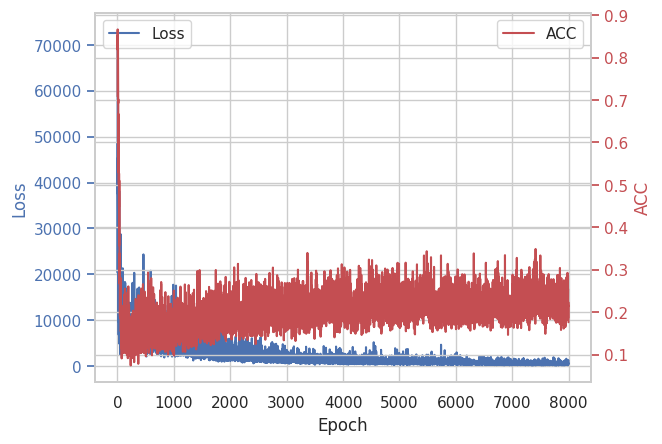

In [46]:
import matplotlib.pyplot as plt
losses_train = [item[0] for item in results_train]
auc_train = [item[1] for item in results_train]

# Create a list of epoch numbers
epochs = list(range(1, len(losses_train) + 1))

# Create a new figure and axis
fig, ax1 = plt.subplots()

# Plot losses_train on the first y-axis
ax1.plot(epochs, losses_train, 'b-', label='Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='b')
ax1.tick_params('y', colors='b')

# Create a second y-axis to plot auc_train
ax2 = ax1.twinx()
ax2.plot(epochs, auc_train, 'r-', label='ACC')
ax2.set_ylabel('ACC', color='r')
ax2.tick_params('y', colors='r')

# Add legends for both y-axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.show()


### Seaborn

In [47]:
import seaborn as sns
losses_train = [item[0] for item in results_train]
acc_train = [item[1] for item in results_train]
losses_test = [item[0] for item in results_test]
acc_test = [item[1] for item in results_test]
epochs = list(range(1, len(losses_train) + 1))

res ={'loss_train': losses_train, 
      'acc_train': acc_train,
      'loss_test': losses_test, 
      'acc_test': acc_test,
      'epoch': epochs
      }
res=pd.DataFrame(res)

##### Loss

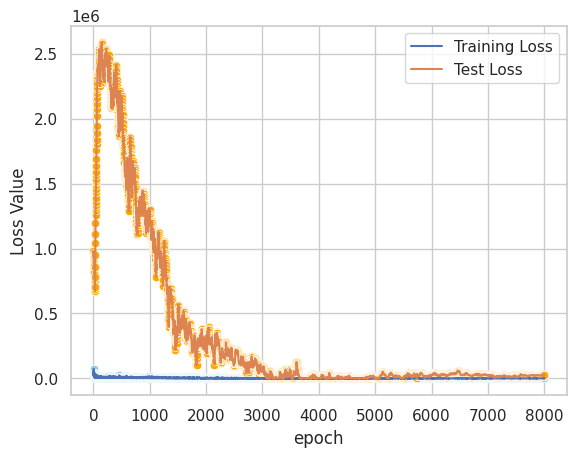

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
line1 = sns.lineplot(x="epoch", y="loss_train", data=res, label='Training Loss')
line2 = sns.lineplot(x="epoch", y="loss_test", data=res, label='Test Loss')


# Add points to each observation
scatter1 = sns.scatterplot(x="epoch", y="loss_train", data=res, marker='o', color='skyblue')
scatter2 = sns.scatterplot(x="epoch", y="loss_test", data=res, marker='o', color='orange')

# Change the y-axis label
plt.ylabel("Loss Value")

# Create a legend for the lines
plt.legend()

# Show the plot
plt.show()



#### Accuracy

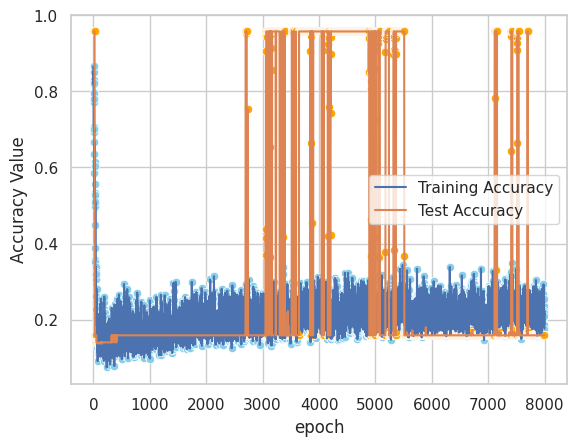

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
line1 = sns.lineplot(x="epoch", y="acc_train", data=res, label='Training Accuracy')
line2 = sns.lineplot(x="epoch", y="acc_test", data=res, label='Test Accuracy')

# Add points to each observation
scatter1 = sns.scatterplot(x="epoch", y="acc_train", data=res, marker='o', color='skyblue')
scatter2 = sns.scatterplot(x="epoch", y="acc_test", data=res, marker='o', color='orange')

# Change the y-axis label
plt.ylabel("Accuracy Value")

# Create a legend for the lines
plt.legend()

# Show the plot
plt.show()



In [50]:
sample_batch = loader_test.__next__()
inputs, targets = sample_batch
for tensor in inputs:
    print(tensor.shape, tensor.dtype)
print("Targets shape:", targets.shape, "dtype:", targets.dtype)


(261, 7) float32
(261, 261) <dtype: 'float32'>
(261,) int64
Targets shape: (261, 2) dtype: float64


/usr/local/lib/python3.8/dist-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


# Evaluate Predictions

In [51]:

predictions = []
targets = []
step = 0
while step < loader_test.steps_per_epoch:
        step += 1
        inputs, target = loader_test.__next__()
        pred = model(inputs, training=False)
        predictions.append(pred)
        targets.append(target)
    
predictions = np.vstack(predictions)
    
targets = np.vstack(targets)
# Post-process the predictions if necessary (e.g., convert probabilities to class labels)
predicted_values = np.argmax(predictions, axis=1)
true_labels = np.argmax(targets,axis =1 )


### Confusion Matrix

In [52]:

from sklearn.metrics import confusion_matrix,roc_auc_score,accuracy_score
conf_mat = confusion_matrix(predicted_values, true_labels)
print(conf_mat)
#


[[ 16 318]
 [  0  44]]


### Final Metrics

In [53]:
auc_score = roc_auc_score(true_labels, predicted_values)
accuracy_score = accuracy_score(true_labels, predicted_values)

print("AUC Score:", auc_score)
print("Accuracy Score:", accuracy_score)

AUC Score: 0.5607734806629834
Accuracy Score: 0.15873015873015872


In [54]:
accuracy_score

0.15873015873015872